In [1]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(123)  # 아래 출력은 난수 생성기 초기화로인해 출력되는 것임.

# 주제 : IMDB 영화 리뷰 데이터 긍부정 분석
    긍정 - label : 1 / 부정 - label : 0

[IMDB 영화 리뷰 데이터 다운 링크](https://ai.stanford.edu/~amaas/data/sentiment/)

1. 링크에서 데이터 다운 후 압축 해제

2. 작업중인 디렉토리에 aclIMDB폴더 이동

# 데이터 전처리

In [2]:
# 리뷰데이터와 레이블 값 저장 (둘이 같은 index)
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/', fname), encoding="utf8") as f:
            review_list += [f.read()]   # 파일.read() 텍스트 파일 읽는 함수 / 만약 텍스트 파일이 여러줄이라면 readline을 for문 돌려야 함
            label_list += [label]
print ('Number of reviews :', len(review_list))
print ('Number of labels :', len(label_list))

  0%|          | 0/12500 [00:00<?, ?it/s]

100%|██████████| 12500/12500 [01:53<00:00, 109.91it/s]

Number of reviews : 25000
Number of labels : 25000


In [3]:
# 데이터 전처리 - 최종 목적은 데이터에 존재하는 모든 단어를 Counter객체 만들기.

# 모든 텍스트 소문자로 변경
review_list = [review.lower() for review in review_list]    

# punctuation은 파이썬 string모델에 포함된 문자열 상수로 모든 구두점 문자를 가지고 있다.
# from string import punctuation
print(f'punctuation의 데이터형식:{type(punctuation)} , 출력:{punctuation}',end='\n\n')
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

# 모든 문자를 하나의 스트링으로 join
reviews_blob = ' '.join(review_list)

# 공백기준 문자 나누기
review_words = reviews_blob.split()
print(f'사용된 단어 개수(중복o) : {len(review_words)}개')

# Counter 객체 사용하여 빈도 수 구하기
count_words = Counter(review_words)

# 빈도 수 기준 내림차순 정렬
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

print(sorted_review_words[:10])

punctuation의 데이터형식:<class 'str'> , 출력:!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~



100%|██████████| 25000/25000 [00:01<00:00, 14281.95it/s]


사용된 단어 개수(중복o) : 5821814개
[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


In [4]:
# word to idx 변환 딕셔너리 생성
vocab_to_token = {word:idx+1 for idx, (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

# 0번 인덱스는 패딩 토큰으로 비워둠

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


In [5]:
# 모든 리뷰 정수화

reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]   # 위에서 정의한 딕셔너리로 해당 word에 맞는 정수로 변환
    reviews_tokenized.append(word_to_token)
print(review_list[0][:20])
print (reviews_tokenized[0][:20])
print(f'리뷰 개수 : {len(reviews_tokenized)}')

bromwell high is a c
[22572, 321, 6, 3, 1077, 219, 8, 2082, 30, 1, 166, 61, 14, 46, 80, 5581, 42, 399, 118, 135]
리뷰 개수 : 25000


In [6]:
# 긍/부정 레이블 정수화
# 긍정 : 1 / 부정 : 0
encoded_label_list = [1 if label =='pos' else 0 for label in label_list]

# 각 리뷰 데이터의 단어 개수 저장 (이유 : 길이가 0인 데이터는 제외 + 패딩할 때 사용)
reviews_len = [len(review) for review in reviews_tokenized]

# 단어 수가 0개는 제외
reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='float32') 

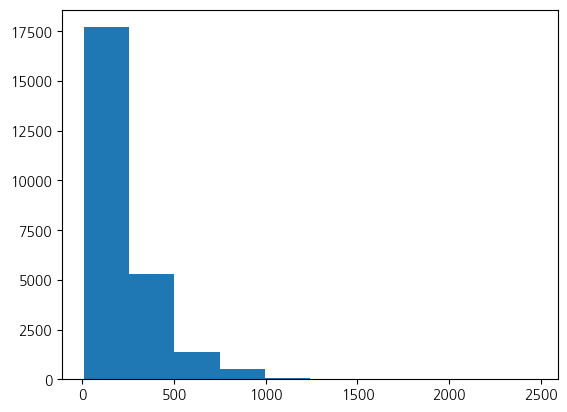

In [7]:
# 리뷰당 단어 개수 시각화
def pad_sequence(reviews_tokenized, sequence_length):
    ''' 
        정해준 시퀀스 길이에 맞게 패딩하는 함수
        짧으면 앞에 0추가
        길면 짜름
    '''

    # 0배열 생성 shape(데이터 개수,512)
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype = int)
    
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        
        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length-review_len))
            new_sequence = zeroes+review    # 패딩+단어
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]    # 길이에 짜름
        
        padded_reviews[idx,:] = np.array(new_sequence)
    
    return padded_reviews

sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length) # Numpy 형태

plt.hist(reviews_len);

In [8]:
# train : test = 0.75 : 0.25 나누기


#### 추가 ################
np.random.seed(42)
indices = np.arange(len(padded_reviews))
np.random.shuffle(indices)

# 랜덤하게 섞인 인덱스를 사용하여 데이터와 라벨을 섞음
padded_reviews = padded_reviews[indices]
encoded_label_list = encoded_label_list[indices]

train_val_split = 0.75
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]
validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

In [9]:
## If while training, you get a runtime error that says: "RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long".
## simply uncomment run the following lines of code additionally
# train_X = train_X.astype('int64')
# train_y = train_y.astype('int64')
# validation_X = validation_X.astype('int64')
# validation_y = validation_y.astype('int64')

In [10]:
# 데이터셋 생성 : x,y 순서로 넣는다.
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device), torch.from_numpy(validation_y).to(device))


# 데이터 로더 생성 : x,y 순서로 나옴.
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [11]:
# 데이터 로더 데이터 양식 : x , y
# x : (Batch, Sequence_length)
# y : (Batch)


train_data_iter = iter(train_dataloader)
X_example, y_example = next(train_data_iter)   # 기존코드 train_data_iter.next()
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[    0,     0,     0,  ...,     2,   119,   376],
        [    0,     0,     0,  ...,   184,    22,   403],
        [   50,     3,    17,  ...,     3, 39795,     4],
        ...,
        [    0,     0,     0,  ...,     3, 28294,   826],
        [    0,     0,     0,  ...,    21,     5,  2284],
        [    0,     0,     0,  ...,    45,     4,   757]], device='cuda:0',
       dtype=torch.int32)

Example Output size:  torch.Size([32])
Example Output:
 tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.],
       device='cuda:0')


# 모델 정의 - RNN

In [12]:
# RNN 모델 정의 - 단층 RNN
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        """
            input_dimension : vocab수 + 1 , 네이밍이 헷갈릴만 함.
            embedding_dimension : word를 표현하는 vector의 차원. 100차원으로 사용
            hidden_dimension : RNN 셀의 hidden_sate 값의 차원. 즉, 리뷰 데이터를 표현하는 차원. 32차원 사용
            output_dimension : 1 긍정 vs 부정 분류이므로 1 or 0사용
        """
        super().__init__()
        # word -> embedding_vector변환
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)

        # RNN레이어 생성. 옜날엔 직접 for문 돌려야했는데 세상 좋아졌..
        # 활성화 함수 tanh사용(default)
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)  

        # Fully connected layer. 즉, 분류기. 32차원->1차원
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)
        
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size) ===> 원랜 (B,S)였음.
        embedding = self.embedding_layer(sequence)  

        # embedding shape = [sequence_length, batch_size, embedding_dimension]

        #           RNN 모델 통과 후

        # output shape = [sequence_length, batch_size, hidden_dimension]    (sequence_length번의 output의 집합)
        # hidden_state shape = [1, batch_size, hidden_dimension]            (sequence_length의 문장을 하나로 표현)

        output, hidden_state = self.rnn_layer(embedding)    

    
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))   # squeeze(0)으로 (Batch,Hidden D)로 변경
        return final_output # (Batch,1)
    
        # PS. 만약 RNN레이어 생성시 batch first=True선언시 output은 (B,S,Embedding V) -> (B,S,Hidden V)으로 출력 됨.
    
input_dimension = len(vocab_to_token)+1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)

optim = torch.optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()

# 참고
# BCEWithLogitsLoss - 이진분류 손실함수 (sigmoid + BCE)
# BCELoss (Binary Cross Entropy) - 이진분류 손실함수 (마지막 레이어가 확률 값으로 변경해야 함)
# CrossEntropyLoss - 다중분류 손실함수 (LogSoftmax + NLLLoss)
# NLLLoss (Negative Log Likelihood) - 다중분류 손실함수 (마지막 레이어가 확률 값으로 변경해야 함 == 로그 확률로 변환되어 들어가야함)

rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

Binary Cross Entropy 수식

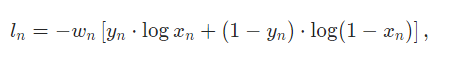

Negative Log Likelihood 수식

$x_{n,y_n}$ 은 $log x_n$ , $y_n$ = 1인 위의 BCE와 동일( (1-$y_n$)은 0이되어 사라지니까)

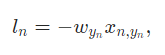

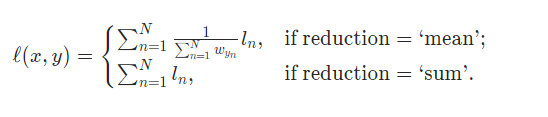

즉, NLL은 각 항을 BCE하고 더하거나 평균낸거다!

In [13]:
# 예측 정확도 구하는 함수
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = torch.round(torch.sigmoid(predictions))   # 반올림
    success = (rounded_predictions == ground_truth).float() # Tensor 데이터형식 지원 함수
    # torch.Tensor([True , True , False]).float() ==> tensor([1., 1., 0.])
    accuracy = success.sum() / len(success) # 몇개중에 몇개맞췄다. == 정확도
    return accuracy

In [14]:
# 훈련 함수
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    
    for sequence, sentiment in dataloader:
        optim.zero_grad()     

        #S.T는 위의 RNN 모델의 batch first옵션이 False라서 배열 전치.
        # (32,512) -> (512,32)
        preds = model(sequence.T).squeeze()
        
        loss_curr = loss_func(preds, sentiment) 
        accuracy_curr = accuracy_metric(preds, sentiment)
        
        loss_curr.backward()
        optim.step()
        
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [15]:
# 검증 함수 (가중치 업데이트 X)
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            
            preds = model(sequence.T).squeeze()
            
            loss_curr = loss_func(preds, sentiment)   
            accuracy_curr = accuracy_metric(preds, sentiment)

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [16]:
# 학습시작 
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

    time_start = time.time()
    
    training_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model, validation_dataloader, loss_func)
    
    time_end = time.time()
    time_delta = time_end - time_start  
    
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
    print()

epoch number: 1 | time elapsed: 4.602057456970215s
training loss: 0.675 | training accuracy: 56.49%
validation loss: 0.646 |  validation accuracy: 61.51%

epoch number: 2 | time elapsed: 3.990135431289673s
training loss: 0.582 | training accuracy: 69.43%
validation loss: 0.578 |  validation accuracy: 72.06%

epoch number: 3 | time elapsed: 3.830918073654175s
training loss: 0.471 | training accuracy: 78.35%
validation loss: 0.542 |  validation accuracy: 74.96%

epoch number: 4 | time elapsed: 3.762218952178955s
training loss: 0.409 | training accuracy: 82.52%
validation loss: 0.558 |  validation accuracy: 74.30%

epoch number: 5 | time elapsed: 3.7924656867980957s
training loss: 0.416 | training accuracy: 81.26%
validation loss: 0.608 |  validation accuracy: 68.42%

epoch number: 6 | time elapsed: 3.784950017929077s
training loss: 0.354 | training accuracy: 85.29%
validation loss: 0.703 |  validation accuracy: 72.02%

epoch number: 7 | time elapsed: 3.7459566593170166s
training loss: 0.

데이터 안섞었을 때 train_acc : 95.77% / val_acc : 62.16%

섞었을 때 train_acc : 90.01% / val_acc : 75.46%

In [17]:
# 추론 코드
def sentiment_inference(model, sentence):
    model.eval()
    
    # text transformations
    sentence = sentence.lower() # 소문자화
    sentence = ''.join([c for c in sentence if c not in punctuation])   # 구두점 제거
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]    # 단어 나누고 정수화 / Vocab에 없는 단어 0으로 반환(패딩 == 무시하겠다.)
    
    # 패딩추가 , 길이가 부족한 경우 앞쪽에 0 추가  / constant 는 상수로 패딩
    # (512-len(tokenized), 0)은 앞에 ~ 개 패딩 , 뒤로 0개 패딩 , constant_values은 default 0
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), 'constant') 
    
    # model inference
    model_input = torch.LongTensor(tokenized).to(device)    #텐서화
    model_input = model_input.unsqueeze(1)  # 차원 맞춰주기 , 배치 1
    pred = torch.sigmoid(model(model_input))    # 확률 계산 0~1사이로 출력
    
    return pred.item()

[np.pad Docs](https://numpy.org/doc/stable/reference/generated/numpy.pad.html)

In [18]:
# 테스트
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "Decent movie, although could be shorter"))
print()
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I loved the movie, every part of it"))
print(sentiment_inference(rnn_model, "It was fun, but I was hungry"))

0.09096695482730865
0.10027404129505157
0.9891836643218994

0.9924572706222534
0.926382839679718
0.9615596532821655
